In [2]:
import pandas as pd
import numpy as np

# Sample hourly data for one day with non-linear relationships
np.random.seed(42)
data = {
    "time": pd.date_range("2024-06-09", periods=1024, freq="H"),
    "mining_input1": np.random.uniform(900, 1100, 1024).astype(int),
    "mining_input2": np.random.uniform(400, 600, 1024).astype(int),
    "coke_input1": np.random.uniform(700, 900, 1024).astype(int),
    "coke_input2": np.random.uniform(200, 400, 1024).astype(int)
}

df = pd.DataFrame(data)

# Define step functions for outputs
def mining_output1_func(input1, input2):
    conditions = [
        (input1 < 950) & (input2 < 500),
        (input1 >= 950) & (input2 < 500),
        (input1 < 950) & (input2 >= 500),
        (input1 >= 950) & (input2 >= 500)
    ]
    values = [800, 900, 1000, 1100]
    return np.select(conditions, values, default=1000)

def mining_ghg_func(input1, input2):
    conditions = [
        (input1 < 950) & (input2 < 500),
        (input1 >= 950) & (input2 < 500),
        (input1 < 950) & (input2 >= 500),
        (input1 >= 950) & (input2 >= 500)
    ]
    values = [40, 45, 50, 55]
    return np.select(conditions, values, default=50)

def coke_output1_func(input1, input2):
    conditions = [
        (input1 < 800) & (input2 < 300),
        (input1 >= 800) & (input2 < 300),
        (input1 < 800) & (input2 >= 300),
        (input1 >= 800) & (input2 >= 300)
    ]
    values = [600, 650, 700, 750]
    return np.select(conditions, values, default=700)

def coke_ghg_func(input1, input2):
    conditions = [
        (input1 < 800) & (input2 < 300),
        (input1 >= 800) & (input2 < 300),
        (input1 < 800) & (input2 >= 300),
        (input1 >= 800) & (input2 >= 300)
    ]
    values = [60, 65, 70, 75]
    return np.select(conditions, values, default=70)

# Apply step functions to generate outputs
df["mining_output1"] = mining_output1_func(df["mining_input1"], df["mining_input2"])
df["mining_ghg"] = mining_ghg_func(df["mining_input1"], df["mining_input2"])
df["coke_output1"] = coke_output1_func(df["coke_input1"], df["coke_input2"])
df["coke_ghg"] = coke_ghg_func(df["coke_input1"], df["coke_input2"])

# Generate frequency tables for all output columns
frequency_tables = {
    "mining_output1": df["mining_output1"].value_counts().sort_index(),
    "mining_ghg": df["mining_ghg"].value_counts().sort_index(),
    "coke_output1": df["coke_output1"].value_counts().sort_index(),
    "coke_ghg": df["coke_ghg"].value_counts().sort_index()
}



pd.DataFrame(frequency_tables)

,mining_output1,mining_ghg,coke_output1,coke_ghg
40,NaN,132.0,NaN,NaN
45,NaN,370.0,NaN,NaN
50,NaN,143.0,NaN,NaN
55,NaN,379.0,NaN,NaN
60,NaN,NaN,NaN,248.0
65,NaN,NaN,NaN,271.0
70,NaN,NaN,NaN,263.0
75,NaN,NaN,NaN,242.0
600,NaN,NaN,248.0,NaN
650,NaN,NaN,271.0,NaN


Mining Output1 MSE: 1359.7464145787778, R2: 0.882266064214865
Mining GHG MSE: 3.399400358506767, R2: 0.882264875501692
Coke Output1 MSE: 263.7396999625027, R2: 0.9149308397350205
Coke GHG MSE: 2.6373968159029584, R2: 0.9149308456609703


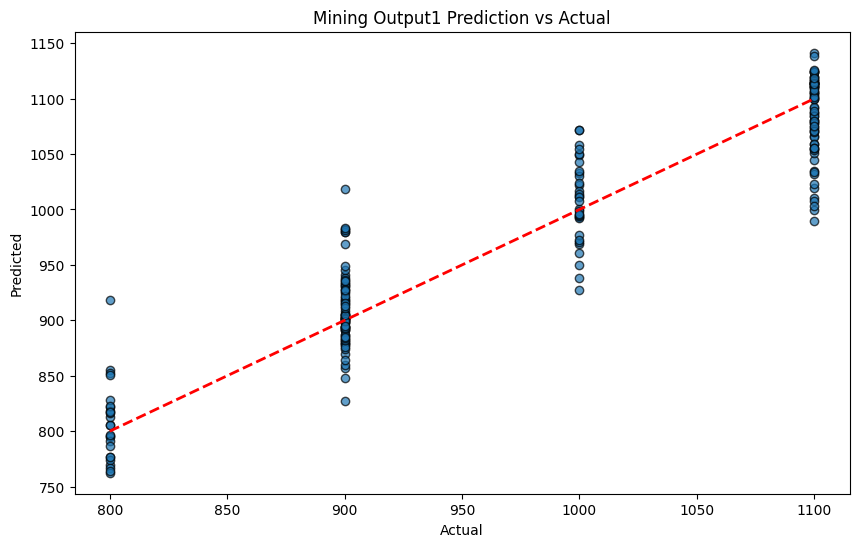

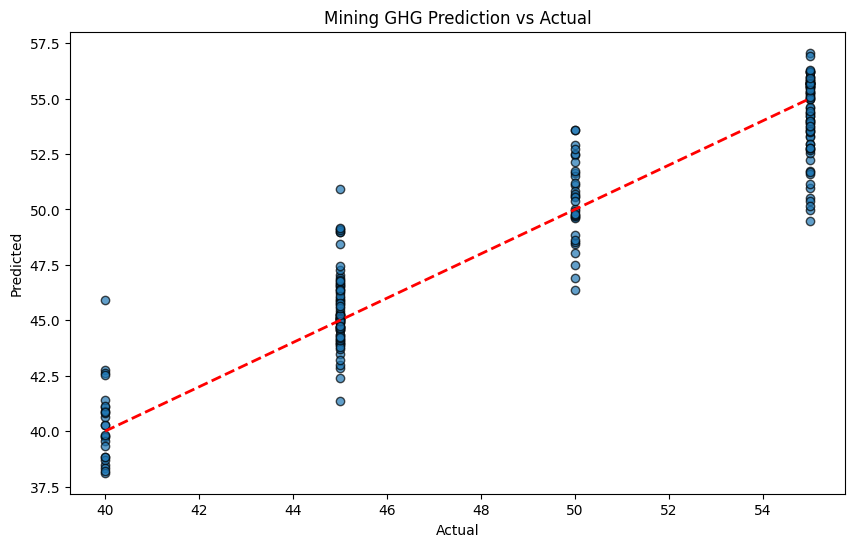

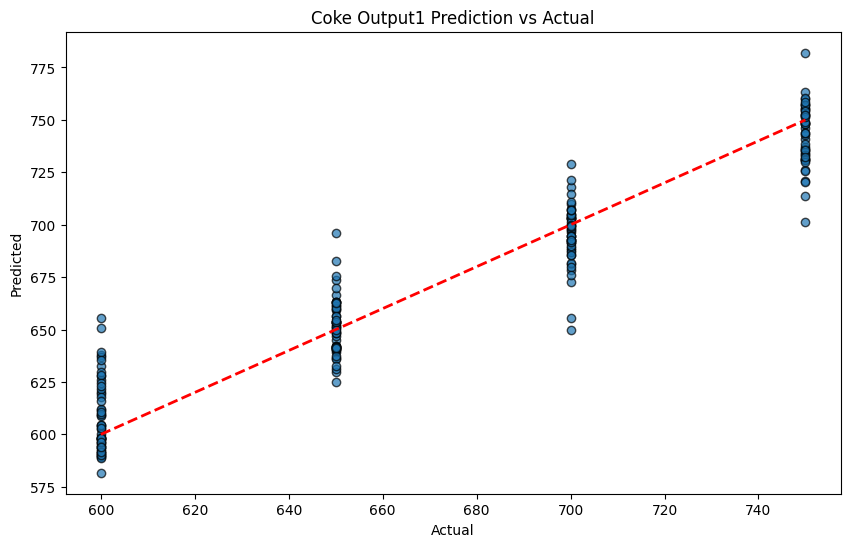

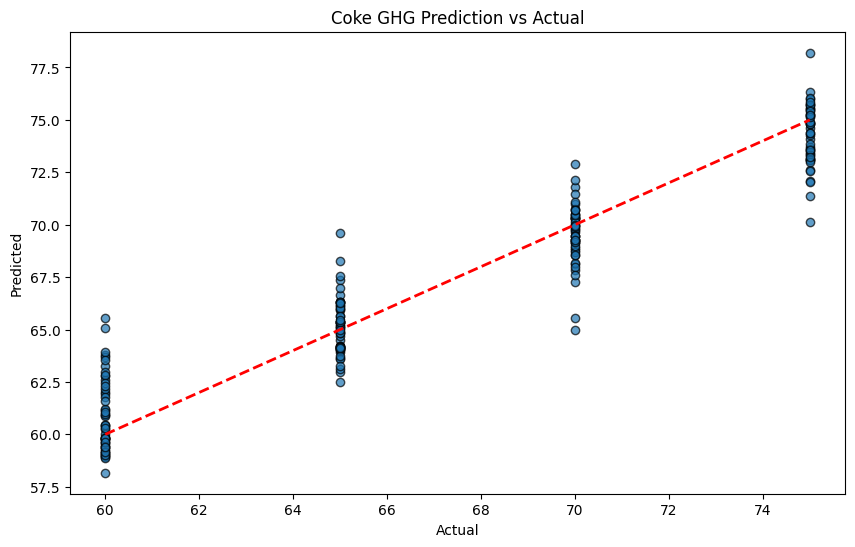

In [5]:
import pandas as pd
import numpy as np
import joblib
import os
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Sample hourly data for one day with non-linear relationships
np.random.seed(42)
data = {
    "time": pd.date_range("2024-06-09", periods=1024, freq="H"),
    "mining_input1": np.random.uniform(900, 1100, 1024).astype(int),
    "mining_input2": np.random.uniform(400, 600, 1024).astype(int),
    "coke_input1": np.random.uniform(700, 900, 1024).astype(int),
    "coke_input2": np.random.uniform(200, 400, 1024).astype(int)
}

df = pd.DataFrame(data)

# Define step functions for outputs
def mining_output1_func(input1, input2):
    conditions = [
        (input1 < 950) & (input2 < 500),
        (input1 >= 950) & (input2 < 500),
        (input1 < 950) & (input2 >= 500),
        (input1 >= 950) & (input2 >= 500)
    ]
    values = [800, 900, 1000, 1100]
    return np.select(conditions, values, default=1000)

def mining_ghg_func(input1, input2):
    conditions = [
        (input1 < 950) & (input2 < 500),
        (input1 >= 950) & (input2 < 500),
        (input1 < 950) & (input2 >= 500),
        (input1 >= 950) & (input2 >= 500)
    ]
    values = [40, 45, 50, 55]
    return np.select(conditions, values, default=50)

def coke_output1_func(input1, input2):
    conditions = [
        (input1 < 800) & (input2 < 300),
        (input1 >= 800) & (input2 < 300),
        (input1 < 800) & (input2 >= 300),
        (input1 >= 800) & (input2 >= 300)
    ]
    values = [600, 650, 700, 750]
    return np.select(conditions, values, default=700)

def coke_ghg_func(input1, input2):
    conditions = [
        (input1 < 800) & (input2 < 300),
        (input1 >= 800) & (input2 < 300),
        (input1 < 800) & (input2 >= 300),
        (input1 >= 800) & (input2 >= 300)
    ]
    values = [60, 65, 70, 75]
    return np.select(conditions, values, default=70)

# Apply step functions to generate outputs
df["mining_output1"] = mining_output1_func(df["mining_input1"], df["mining_input2"])
df["mining_ghg"] = mining_ghg_func(df["mining_input1"], df["mining_input2"])
df["coke_output1"] = coke_output1_func(df["coke_input1"], df["coke_input2"])
df["coke_ghg"] = coke_ghg_func(df["coke_input1"], df["coke_input2"])

# Check for and handle NaN values
if df.isnull().values.any():
    print("DataFrame contains NaN values. Dropping NaNs.")
    df = df.dropna()

# Split data into training and testing sets
X_mining = df[["mining_input1", "mining_input2"]]
y_mining_output1 = df["mining_output1"]
y_mining_ghg = df["mining_ghg"]

X_coke = df[["coke_input1", "coke_input2"]]
y_coke_output1 = df["coke_output1"]
y_coke_ghg = df["coke_ghg"]

X_mining_train, X_mining_test, y_mining_output1_train, y_mining_output1_test = train_test_split(X_mining, y_mining_output1, test_size=0.2, random_state=42)
X_mining_train, X_mining_test, y_mining_ghg_train, y_mining_ghg_test = train_test_split(X_mining, y_mining_ghg, test_size=0.2, random_state=42)

X_coke_train, X_coke_test, y_coke_output1_train, y_coke_output1_test = train_test_split(X_coke, y_coke_output1, test_size=0.2, random_state=42)
X_coke_train, X_coke_test, y_coke_ghg_train, y_coke_ghg_test = train_test_split(X_coke, y_coke_ghg, test_size=0.2, random_state=42)

# Function to train and evaluate polynomial regression models
def train_and_evaluate_poly_model(X_train, y_train, X_test, y_test, degree):
    poly = PolynomialFeatures(degree)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)
    
    model = LinearRegression()
    model.fit(X_train_poly, y_train)
    
    y_pred = model.predict(X_test_poly)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    return model, poly, mse, r2, y_pred

# Train models
degree = 6  # Degree of the polynomial features

# Mining models
mining_output1_model, mining_output1_poly, mining_output1_mse, mining_output1_r2, mining_output1_pred = train_and_evaluate_poly_model(X_mining_train, y_mining_output1_train, X_mining_test, y_mining_output1_test, degree)
mining_ghg_model, mining_ghg_poly, mining_ghg_mse, mining_ghg_r2, mining_ghg_pred = train_and_evaluate_poly_model(X_mining_train, y_mining_ghg_train, X_mining_test, y_mining_ghg_test, degree)

# Coke models
coke_output1_model, coke_output1_poly, coke_output1_mse, coke_output1_r2, coke_output1_pred = train_and_evaluate_poly_model(X_coke_train, y_coke_output1_train, X_coke_test, y_coke_output1_test, degree)
coke_ghg_model, coke_ghg_poly, coke_ghg_mse, coke_ghg_r2, coke_ghg_pred = train_and_evaluate_poly_model(X_coke_train, y_coke_ghg_train, X_coke_test, y_coke_ghg_test, degree)

# Save models
if not os.path.exists('models'):
    os.makedirs('models')

joblib.dump((mining_output1_model, mining_output1_poly), 'models/mining_output1_model.pkl')
joblib.dump((mining_ghg_model, mining_ghg_poly), 'models/mining_ghg_model.pkl')
joblib.dump((coke_output1_model, coke_output1_poly), 'models/coke_output1_model.pkl')
joblib.dump((coke_ghg_model, coke_ghg_poly), 'models/coke_ghg_model.pkl')

# Display MSE and R2
print(f"Mining Output1 MSE: {mining_output1_mse}, R2: {mining_output1_r2}")
print(f"Mining GHG MSE: {mining_ghg_mse}, R2: {mining_ghg_r2}")
print(f"Coke Output1 MSE: {coke_output1_mse}, R2: {coke_output1_r2}")
print(f"Coke GHG MSE: {coke_ghg_mse}, R2: {coke_ghg_r2}")

# Plot performance of the models
def plot_performance(y_test, y_pred, title):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, edgecolor='k', alpha=0.7)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(title)
    plt.show()

plot_performance(y_mining_output1_test, mining_output1_pred, "Mining Output1 Prediction vs Actual")
plot_performance(y_mining_ghg_test, mining_ghg_pred, "Mining GHG Prediction vs Actual")
plot_performance(y_coke_output1_test, coke_output1_pred, "Coke Output1 Prediction vs Actual")
plot_performance(y_coke_ghg_test, coke_ghg_pred, "Coke GHG Prediction vs Actual")